# What music do I like?

Here we will analyze my favorite artists in search for properties I like. First, we must get the data to analyze.

To do this, we will use the [Spotipy](https://spotipy.readthedocs.io/en/2.19.0/#) library, which provides a wrapper for the Spotify Web API. With this API, we can ask the API for information about my favorite artists, as well as other random artists in order to later train models that will look into the properties of the music I like.

## 1. Authenticating into the spotify API and getting data.

The Spotipy library offers two ways of authenticating: Authorization Code Flow and Client Credentials Flow. The first allows us to access a user's data, but has a lower rate limit than the second. Since I already know which artists I like, we can use Client Credentials to authenticate.

In [1]:
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

from secrets import *    # We save the credentials in a file that we import. This file is included in the .gitignore to avoid leaking our credentials.

auth_manager = SpotifyClientCredentials(client_id=CLIENT_ID, client_secret=CLIENT_SECRET)
sp = spotipy.Spotify(auth_manager=auth_manager)

Now we need to get data from the artists I like. We can ask Spotify to give us information about my user, but I log my data to Last.fm, where I can use it along with older data from way before I used Spotify. Since this data is more complete, I will use this instead of Spotify's. 

In [2]:
fav_artists = ['The National',
              'Death Cab for Cutie',
              'Vetusta Morla',
              'Interpol',
              'Radiohead',
              'Foals',
              'Manchester Orchestra',
              'Arctic Monkeys',
              'Arcade Fire',
              'Incubus']


Now let's define a function that takes a list of artists and gets us a list of songs with song ids. We will use this later to get audio features for each song.

In [3]:
def get_songlist(artists):
    songlist = []
    
    for artist in artists:
        artist_id = sp.search(artist, type='artist', limit = 1)['artists']['items'][0]['id']
        discography = sp.artist_albums(artist_id, album_type='album')
        
        trackids = []
        for album in discography['items']:
            for track in sp.album_tracks(album['id'])['items']:
                trackids.append(track['id'])
               
        prev = 0
        for x in range(0, len(trackids), 50):
            features = sp.audio_features(trackids[prev:x])
            
            for song in features:
                if song:
                    song['artist'] = artist
                
            songlist += features
            prev = x
              
    return songlist

In [4]:
fav_songs = get_songlist(fav_artists)

In [5]:
fav_songs[1]

{'danceability': 0.424,
 'energy': 0.337,
 'key': 2,
 'loudness': -11.554,
 'mode': 1,
 'speechiness': 0.0345,
 'acousticness': 0.798,
 'instrumentalness': 0.62,
 'liveness': 0.114,
 'valence': 0.108,
 'tempo': 119.901,
 'type': 'audio_features',
 'id': '1kje7rdBRPVLdJjhurLSZw',
 'uri': 'spotify:track:1kje7rdBRPVLdJjhurLSZw',
 'track_href': 'https://api.spotify.com/v1/tracks/1kje7rdBRPVLdJjhurLSZw',
 'analysis_url': 'https://api.spotify.com/v1/audio-analysis/1kje7rdBRPVLdJjhurLSZw',
 'duration_ms': 378840,
 'time_signature': 4,
 'artist': 'The National'}

## 2. Initial analysis

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl

mpl.rcParams['figure.dpi'] = 100
plt.style.use('ggplot')

In [7]:
df = pd.DataFrame([x for x in fav_songs if x])

In [8]:
df.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.424   0.337    2   -11.554     1       0.0345       0.79800   
1         0.629   0.615    9    -7.732     0       0.0318       0.02900   
2         0.479   0.441    4    -8.938     1       0.0270       0.78500   
3         0.403   0.618    7    -7.978     1       0.0278       0.07320   
4         0.312   0.822    7    -4.759     1       0.0494       0.00018   

   instrumentalness  liveness  valence    tempo            type  \
0             0.620     0.114    0.108  119.901  audio_features   
1             0.259     0.189    0.452  129.977  audio_features   
2             0.126     0.110    0.110  103.002  audio_features   
3             0.587     0.279    0.220  133.113  audio_features   
4             0.679     0.214    0.266  148.926  audio_features   

                       id                                   uri  \
0  1kje7rdBRPVLdJjhurLSZw  spotify:track:1kje7rdBRPVLdJjhurLSZw   
1  09b8mr09RVCoj327bBpaPS  spotify:track:09b8mr09RVCoj327bBpaPS   
2  70YTeIt85PXWV2pJyBTGdN  spotify:track:70YTeIt85PXWV2pJyBTGdN   
3  3atyVUHESb82hi3d8VKEqg  spotify:track:3atyVUHESb82hi3d8VKEqg   
4  0e6Ndkr4xwChsbOIjKUgUj  spotify:track:0e6Ndkr4xwChsbOIjKUgUj   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/1kje7rdBRPVL...   
1  https://api.spotify.com/v1/tracks/09b8mr09RVCo...   
2  https://api.spotify.com/v1/tracks/70YTeIt85PXW...   
3  https://api.spotify.com/v1/tracks/3atyVUHESb82...   
4  https://api.spotify.com/v1/tracks/0e6Ndkr4xwCh...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/1kje...       378840   
1  https://api.spotify.com/v1/audio-analysis/09b8...       202627   
2  https://api.spotify.com/v1/audio-analysis/70YT...       224213   
3  https://api.spotify.com/v1/audio-analysis/3aty...       277107   
4  https://api.spotify.com/v1/audio-analysis/0e6N...       225720   

   time_signature        artist  
0               4  The National  
1               4  The National  
2               4  The National  
3               4  The National  
4               4  The National

In [9]:
df.describe()

danceability       energy          key     loudness         mode  \
count   1798.000000  1798.000000  1798.000000  1798.000000  1798.000000   
mean       0.474529     0.666919     5.312570    -8.385623     0.632369   
std        0.149071     0.240683     3.644034     4.673894     0.482294   
min        0.000000     0.003790     0.000000   -37.135000     0.000000   
25%        0.367000     0.513000     2.000000    -9.673500     0.000000   
50%        0.482000     0.725000     6.000000    -7.203500     1.000000   
75%        0.576000     0.859750     9.000000    -5.556000     1.000000   
max        0.965000     0.995000    11.000000    -1.703000     1.000000   

       speechiness  acousticness  instrumentalness     liveness      valence  \
count  1798.000000   1798.000000       1798.000000  1798.000000  1798.000000   
mean      0.067999      0.247032          0.282122     0.248609     0.398647   
std       0.114159      0.313389          0.338555     0.237536     0.232140   
min       0.000000      0.000003          0.000000     0.000000     0.000000   
25%       0.032500      0.006160          0.001040     0.102000     0.207000   
50%       0.039900      0.074100          0.074100     0.132500     0.368000   
75%       0.057000      0.419500          0.610500     0.306750     0.571750   
max       0.944000      0.996000          0.993000     0.985000     0.978000   

             tempo   duration_ms  time_signature  
count  1798.000000  1.798000e+03     1798.000000  
mean    124.008942  2.545334e+05        3.861513  
std      28.159130  1.324467e+05        0.469739  
min       0.000000  3.329000e+03        0.000000  
25%     103.980500  2.037330e+05        4.000000  
50%     123.864500  2.463730e+05        4.000000  
75%     142.183250  2.918035e+05        4.000000  
max     204.629000  4.431894e+06        5.000000

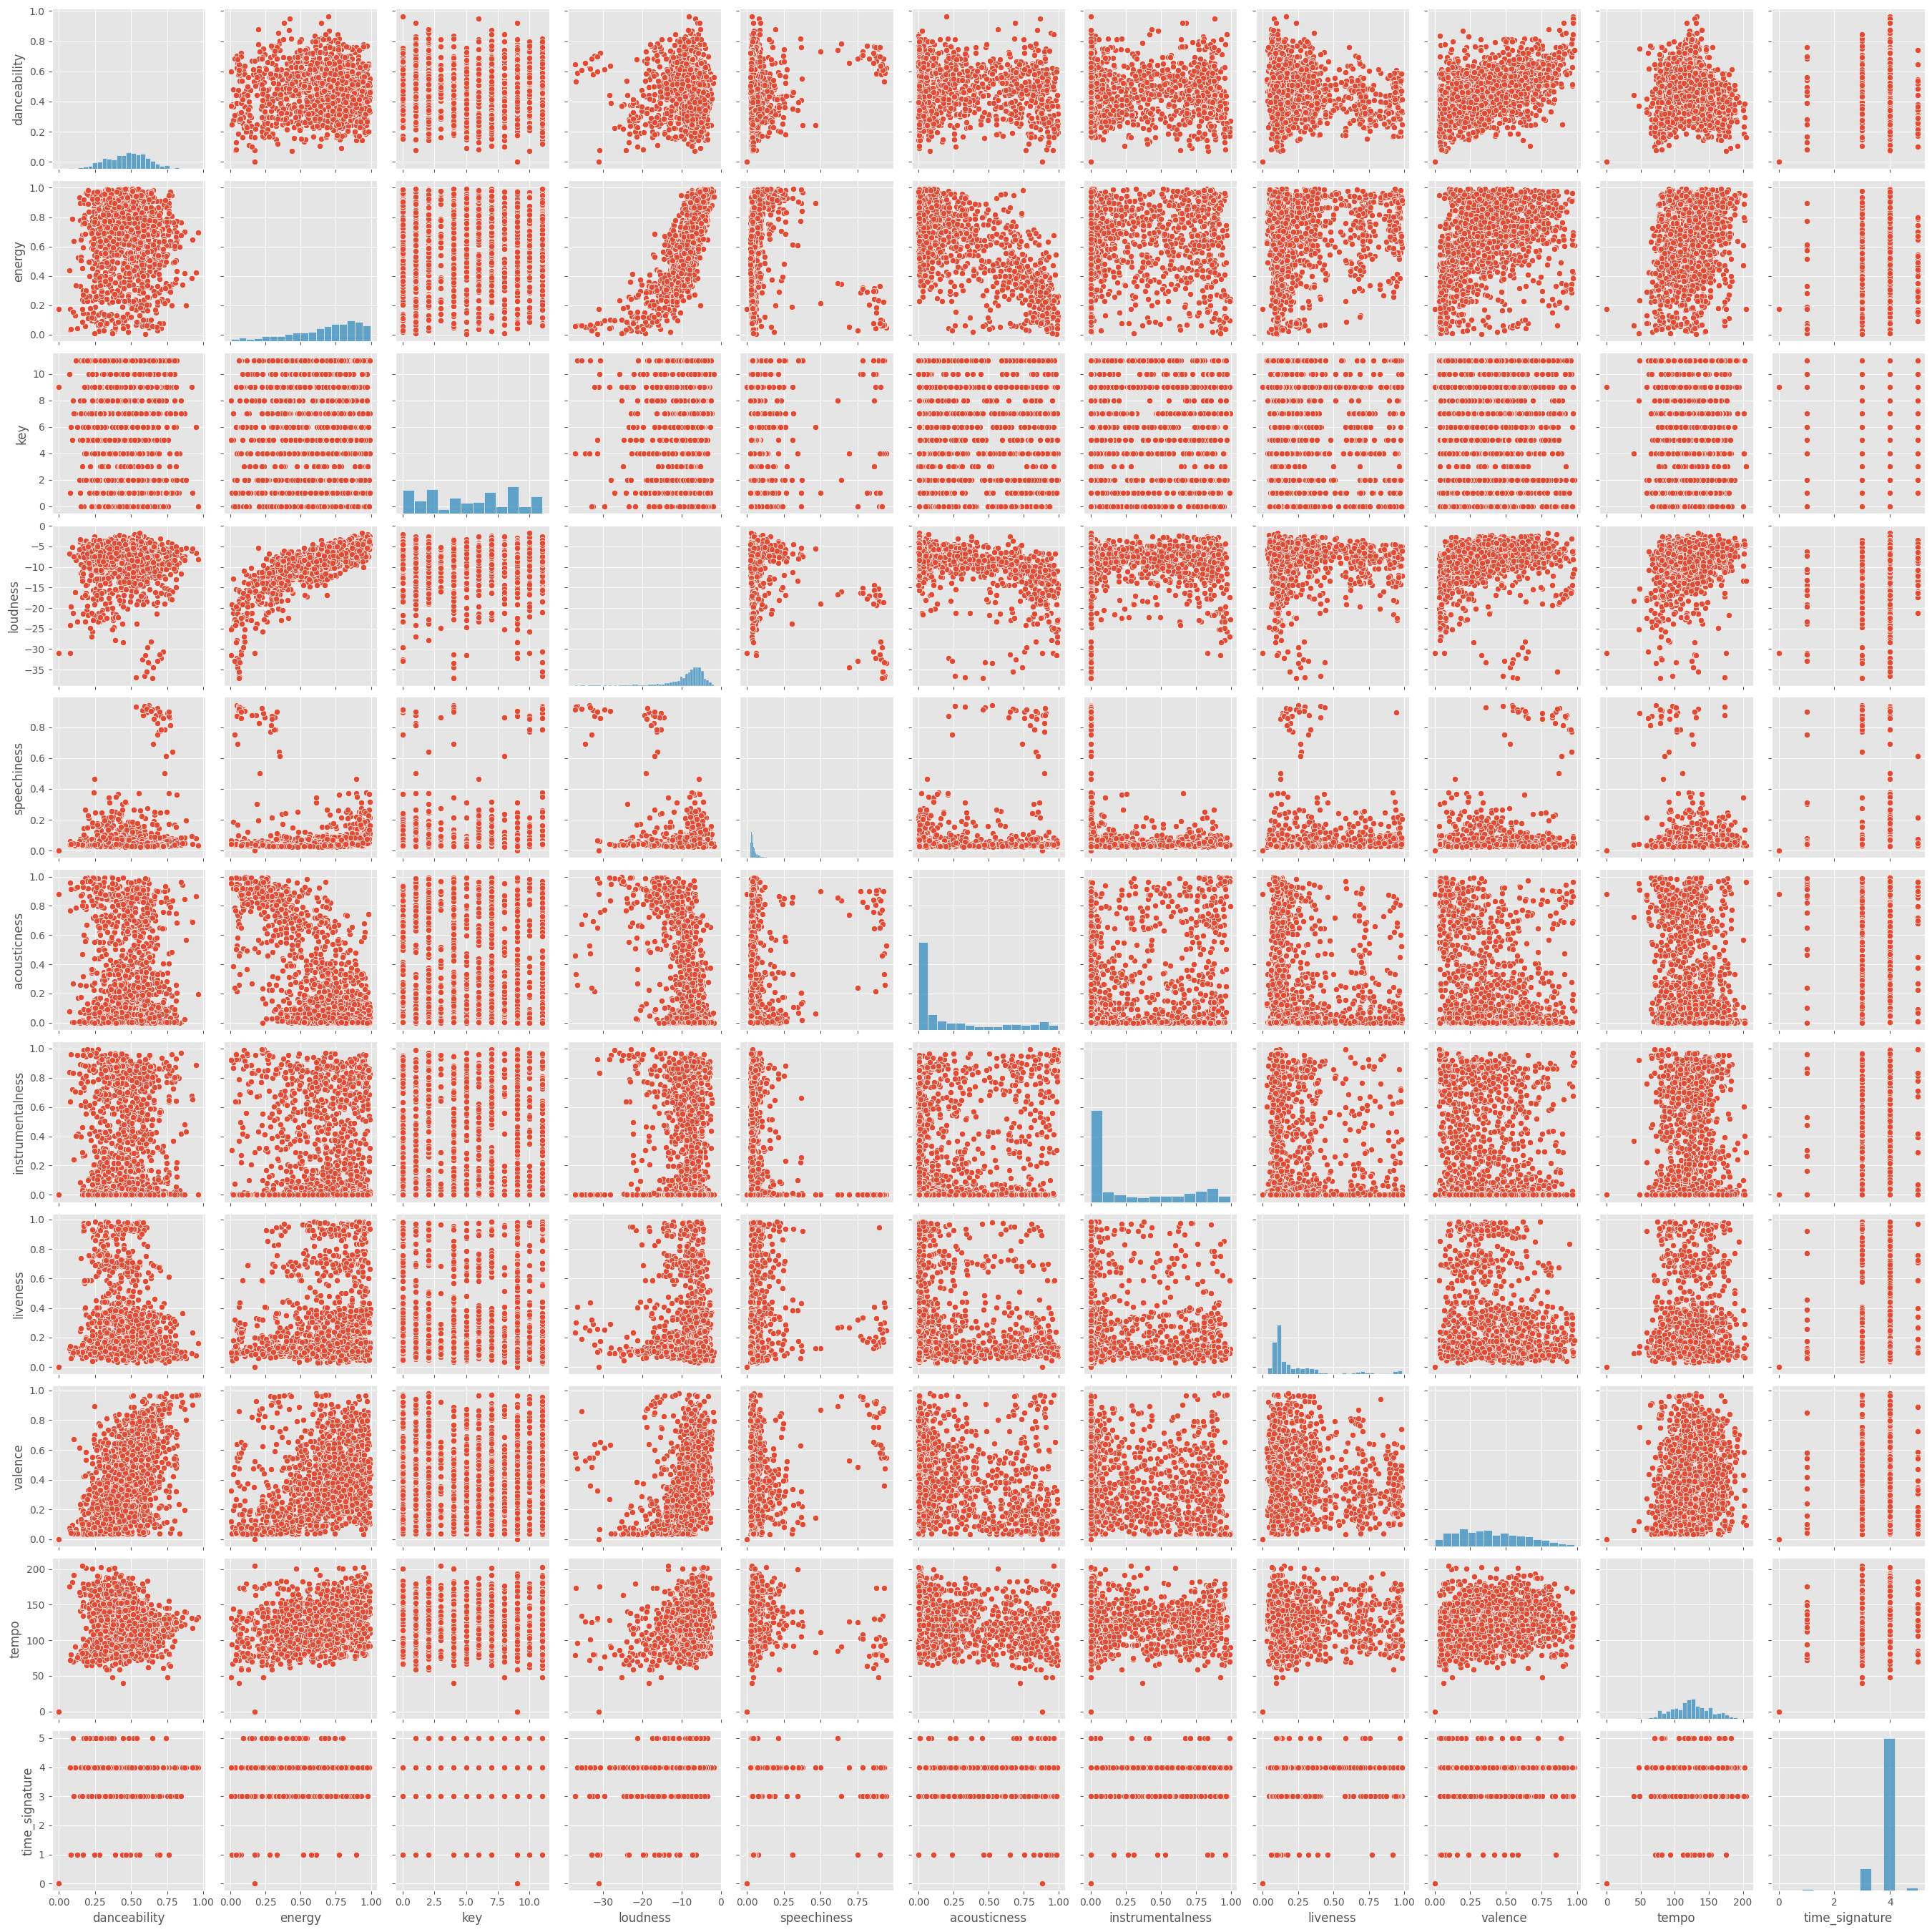

In [10]:
features = ['danceability',
           'energy',
           'key',
           'loudness',
           'speechiness',
           'acousticness',
           'instrumentalness',
           'liveness',
           'valence',
           'tempo',
           'time_signature']


sns.pairplot(df[features])

Seems already that there are some interesting patterns in the data.

### I like energetic, loud music

<AxesSubplot:xlabel='loudness', ylabel='Count'>

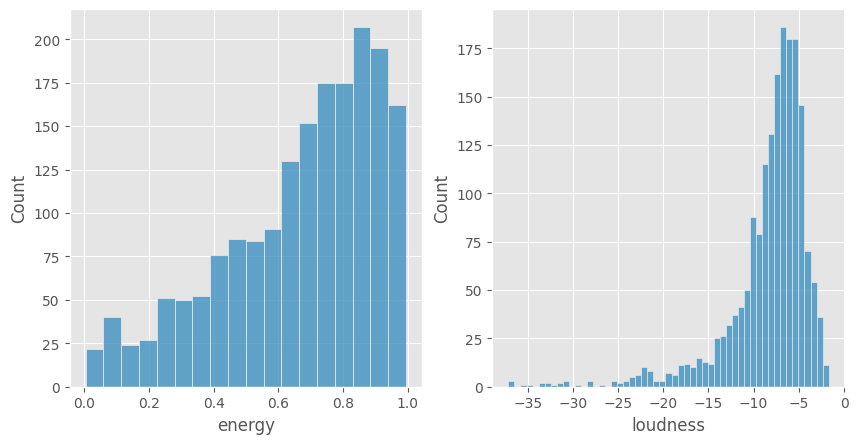

In [11]:
fig = plt.subplots(1, 2, figsize = (10, 5))

sns.histplot(df['energy'], ax = fig[1][0])
sns.histplot(df['loudness'], ax = fig[1][1])

There's even a relation between energy and loudness, i.e., the louder a song is, the more energetic Spotify thinks it is.

<AxesSubplot:xlabel='loudness', ylabel='energy'>

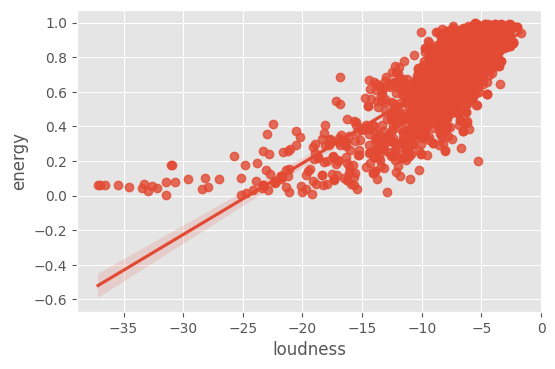

In [12]:
sns.regplot(x = df['loudness'], y = df['energy'])

### Do I like sad music? 

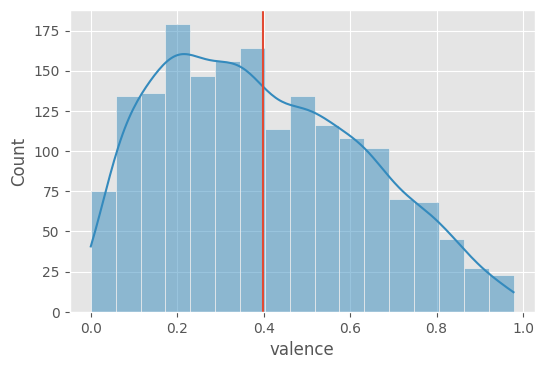

In [13]:
sns.histplot(df['valence'], kde=True)
plt.axvline(df['valence'].mean())

# 3. Comparing with other music

To compare to other music, I will sample songs from top hits playlists. This will give us an idea of my tastes relative to the most popular songs of the moment.

In [14]:
top_playlists = sp.search(q = 'Top Hits', type = 'playlist', limit = 25)['playlists']['items']

In [15]:
tophits = []
for playlist in top_playlists:
    tophits += sp.playlist_items(playlist['id'])['items']

In [16]:
not_fav_ids = []
for song in tophits:
    not_fav_ids.append(song['track']['id'])

In [17]:
len(not_fav_ids)

2153

In [18]:
not_fav_features = []

prev = 0
for x in range(0, len(not_fav_ids), 50):
    features = sp.audio_features(not_fav_ids[prev:x])
    
    for song in features:            
        not_fav_features += features
    
    prev = x

In [19]:
not_fav_df = pd.DataFrame([x for x in not_fav_features if x])

In [20]:
not_fav_df.drop_duplicates(subset = ['id'], inplace = True)
not_fav_df.head()

danceability  energy  key  loudness  mode  speechiness  acousticness  \
0         0.637   0.843    5    -5.413     1       0.0432       0.01510   
1         0.749   0.925   10    -5.034     1       0.2270       0.24100   
2         0.696   0.921    0    -3.755     1       0.0363       0.00314   
3         0.673   0.886    1    -4.440     0       0.0431       0.18500   
4         0.755   0.837    2    -2.718     0       0.1420       0.09910   

   instrumentalness  liveness  valence    tempo            type  \
0          0.000000    0.0876    0.434  109.012  audio_features   
1          0.000000    0.5200    0.641   86.989  audio_features   
2          0.000052    0.0842    0.714  119.001  audio_features   
3          0.000000    0.0826    0.795   97.012  audio_features   
4          0.000000    0.2890    0.714  120.028  audio_features   

                       id                                   uri  \
0  47Slg6LuqLaX0VodpSCvPt  spotify:track:47Slg6LuqLaX0VodpSCvPt   
1  15JINEqzVMv3SvJTAXAKED  spotify:track:15JINEqzVMv3SvJTAXAKED   
2  0SiywuOBRcynK0uKGWdCnn  spotify:track:0SiywuOBRcynK0uKGWdCnn   
3  4HlFJV71xXKIGcU3kRyttv  spotify:track:4HlFJV71xXKIGcU3kRyttv   
4  0HPD5WQqrq7wPWR7P7Dw1i  spotify:track:0HPD5WQqrq7wPWR7P7Dw1i   

                                          track_href  \
0  https://api.spotify.com/v1/tracks/47Slg6LuqLaX...   
1  https://api.spotify.com/v1/tracks/15JINEqzVMv3...   
2  https://api.spotify.com/v1/tracks/0SiywuOBRcyn...   
3  https://api.spotify.com/v1/tracks/4HlFJV71xXKI...   
4  https://api.spotify.com/v1/tracks/0HPD5WQqrq7w...   

                                        analysis_url  duration_ms  \
0  https://api.spotify.com/v1/audio-analysis/47Sl...       220733   
1  https://api.spotify.com/v1/audio-analysis/15JI...       263373   
2  https://api.spotify.com/v1/audio-analysis/0Siy...       294573   
3  https://api.spotify.com/v1/audio-analysis/4HlF...       216773   
4  https://api.spotify.com/v1/audio-analysis/0HPD...       199693   

   time_signature  
0               4  
1               4  
2               4  
3               4  
4               4

In [21]:
not_fav_df.describe()

danceability       energy          key     loudness         mode  \
count   1825.000000  1825.000000  1825.000000  1825.000000  1825.000000   
mean       0.631838     0.695289     5.293151    -6.087719     0.624110   
std        0.137107     0.169428     3.650445     2.588212     0.484485   
min        0.149000     0.042700     0.000000   -24.709000     0.000000   
25%        0.549000     0.591000     2.000000    -7.144000     0.000000   
50%        0.648000     0.717000     6.000000    -5.554000     1.000000   
75%        0.729000     0.828000     8.000000    -4.371000     1.000000   
max        0.965000     0.986000    11.000000    -1.131000     1.000000   

       speechiness  acousticness  instrumentalness     liveness      valence  \
count  1825.000000   1825.000000       1825.000000  1825.000000  1825.000000   
mean      0.079282      0.195806          0.009548     0.177604     0.546108   
std       0.071849      0.229918          0.070620     0.135810     0.218935   
min       0.023200      0.000029          0.000000     0.021000     0.038100   
25%       0.035100      0.021000          0.000000     0.091000     0.375000   
50%       0.049000      0.097500          0.000000     0.121000     0.552000   
75%       0.090700      0.301000          0.000053     0.234000     0.725000   
max       0.536000      0.970000          0.985000     0.979000     0.973000   

             tempo    duration_ms  time_signature  
count  1825.000000    1825.000000     1825.000000  
mean    120.998168  223241.755068        3.967671  
std      27.184900   41644.439555        0.237739  
min      60.019000   92250.000000        1.000000  
25%      99.316000  198835.000000        4.000000  
50%     122.009000  219200.000000        4.000000  
75%     136.035000  242974.000000        4.000000  
max     208.196000  688453.000000        5.000000

In [22]:
all_df = pd.merge(df, not_fav_df, how='outer', indicator = 'fav')

In [23]:
all_df = all_df.replace('left_only', 'fav').replace('right_only', 'not fav')

In [24]:
all_df['fav'] = all_df['fav'].cat.remove_unused_categories()

In [25]:
all_df.replace(0, np.nan, inplace = True)

In [26]:
features = ['danceability',
           'energy',
           'key',
           'loudness',
           'speechiness',
           'acousticness',
           'instrumentalness',
           'liveness',
           'valence',
           'tempo',
           'time_signature',
           'fav']

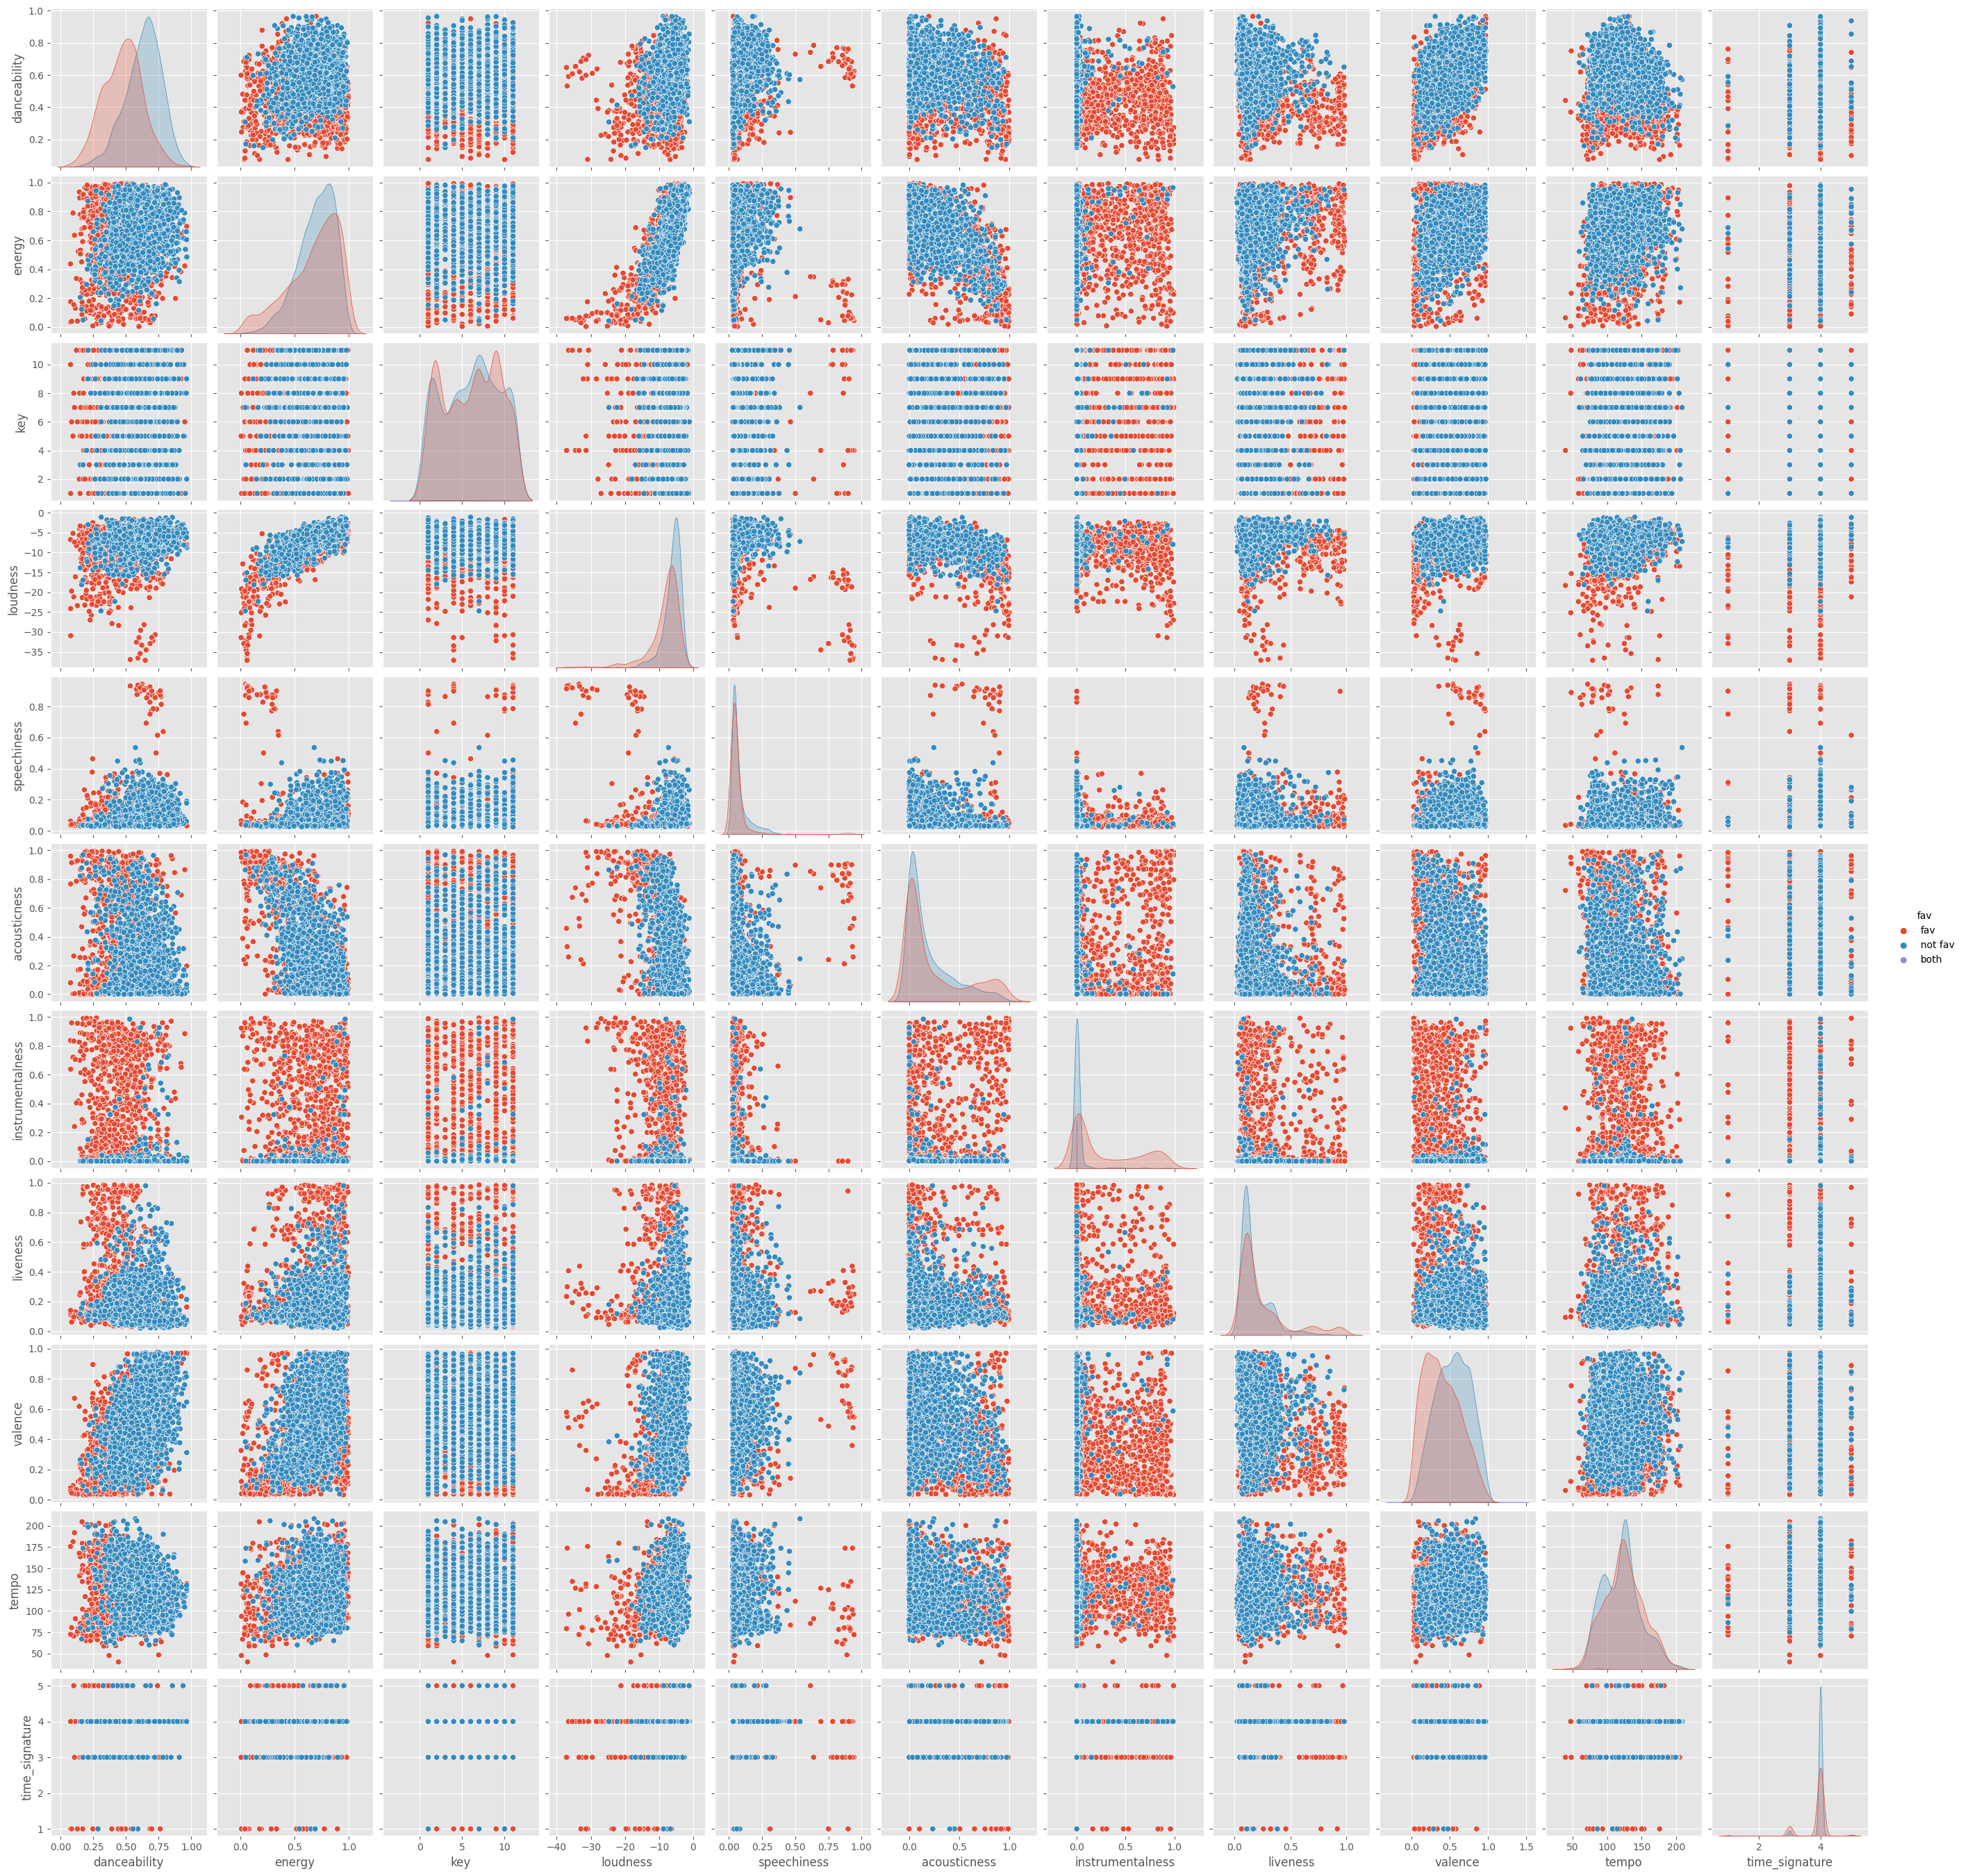

In [27]:
sns.pairplot(all_df[features], hue='fav')

### Top hits are more danceable than my tastes

It seems that top hits tend to be more danceable. Let's test this hypothesis.

<AxesSubplot:xlabel='fav', ylabel='danceability'>

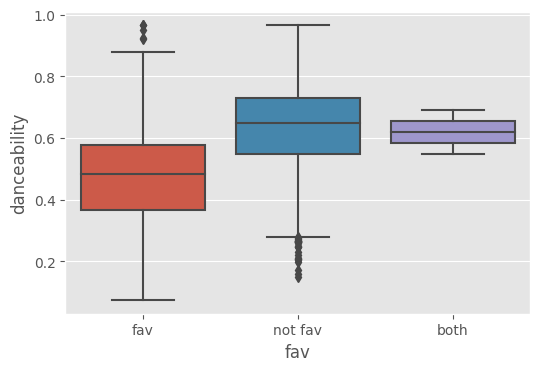

In [28]:
sns.boxplot(data = all_df, y = 'danceability', x = 'fav')

In [29]:
all_df.groupby('fav')['danceability'].describe()

count      mean       std     min      25%     50%      75%    max
fav                                                                         
fav      1795.0  0.474632  0.148676  0.0747  0.36700  0.4820  0.57600  0.965
not fav  1823.0  0.631852  0.137161  0.1490  0.54900  0.6480  0.72950  0.965
both        2.0  0.619500  0.101116  0.5480  0.58375  0.6195  0.65525  0.691

* $H_0$: Not fav danceability is not greater than fav danceability.
* $H_1$: Not fav danceability is greater than fav danceability.

In [30]:
from scipy import stats

stat, pVal = stats.ttest_ind(a = not_fav_df['danceability'], b = df['danceability'], alternative='greater')

print(f"t = {stat:.3f}, p < {pVal:.3f}")

t = 33.067, p < 0.000


Given that p < 0.05, we can assume that the danceability of not favorite songs is greater than danceability of favorite songs.

### I like sadder music than top hits.

<AxesSubplot:xlabel='valence', ylabel='Count'>

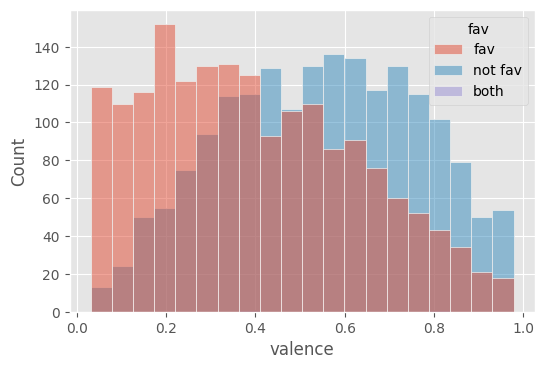

In [31]:
sns.histplot(data = all_df, x = 'valence', hue = 'fav')

* $H_0$: Not fav valence is not greater than fav valence.
* $H_1$: Not fav valence is greater than fav valence.

In [32]:
stat, pVal = stats.ttest_ind(a = not_fav_df['valence'], b = df['valence'], alternative='greater')

print(f"t = {stat:.3f}, p < {pVal:.3f}")

t = 19.672, p < 0.000


Given that p < 0.05, we can assume that I like sadder songs than the current top songs.

## 4. Saving the dataset

Now I will save the dataset to do some ML later one. I will not save any song ids or any identifying information in case there is a problem publishing this information.

In [33]:
all_df[features].to_csv('data.csv')